In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ema_workbench import (MultiprocessingEvaluator,
                           Scenario, Constraint, Policy,
                           ScalarOutcome)
from ema_workbench.em_framework.optimization import EpsilonProgress, HyperVolume
from ema_workbench.em_framework.evaluators import perform_experiments, optimize
from ema_workbench.util import ema_logging, save_results, load_results
from ema_workbench.analysis import (pairs_plotting, prim, 
                                    feature_scoring, parcoords,
                                    dimensional_stacking)

from problem_formulation import get_model_for_problem_formulation
%matplotlib inline
sns.set_style('white')

ema_logging.log_to_stderr(ema_logging.INFO)

C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


<Logger EMA (DEBUG)>

In [2]:
SEED = 42
np.random.seed(SEED) # set seed for reproducibility

In [3]:
'''
For different list of outcomes:
# 0 = 2-objective PF
# 1 = 3-objective PF
# 2 = 5-objective PF
# 3 = Disaggregate over locations
# 4 = Disaggregate over time
# 5 = Fully disaggregated
'''
dike_model, planning_steps = get_model_for_problem_formulation(4) # assign problem_formulation_id

## Reference policies: dike heightening

In [4]:
# with dike heightening policies of different scales
ref_DikeIncrease = {'Small': 1, 'Medium': 5, 'Large': 10}

policyDike = {}
for key in dike_model.levers:
    if 'DikeIncrease 0' in key.name:  # DikeIncrease
        policyDike.update({key.name: np.array([ref_DikeIncrease['Small'],
                                               ref_DikeIncrease['Medium'], 
                                               ref_DikeIncrease['Large']])})
    else:  # RfR and DaysToThreat = 0
        policyDike.update({key.name: np.zeros(len(ref_DikeIncrease))})
        
policies_to_evaluate = [Policy('policyDike'+str(i), **policy.to_dict()) 
                        for i, policy in pd.DataFrame.from_dict(policyDike).iterrows()]

In [5]:
n_scenarios = 3000 # per referenced policy

In [6]:
%%time
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(scenarios= n_scenarios,
                                            policies = policies_to_evaluate,
                                            uncertainty_sampling='lhs')

save_results(results, './results/policyDike0_lhs_9000runs_disaggOverTime.tar.gz')

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 3000 scenarios * 3 policies * 1 model(s) = 9000 experiments
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4500 cases completed
[MainProcess/INFO] 5400 cases completed
[MainProcess/INFO] 6300 cases completed
[MainProcess/INFO] 7200 cases completed
[MainProcess/INFO] 8100 cases completed
[MainProcess/INFO] 9000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
[MainProcess/INFO] results saved successfully to D:\EPA\EPA Semester-1.4\EPA1361 Model-based Decision-making\MBDM-group-11\final assignment\results\policyDike0_lhs_9000runs_disaggOverTime.tar.gz


Wall time: 1h 32min 54s


## Visualize results

In [3]:
results = load_results(r'./results/policyDike0_lhs_9000runs_disaggOverTime.tar.gz')

experiments, outcomes = results

[MainProcess/INFO] results loaded succesfully from D:\EPA\EPA Semester-1.4\EPA1361 Model-based Decision-making\MBDM-group-11\final assignment\results\policyDike0_lhs_9000runs_disaggOverTime.tar.gz


In [15]:
# take a look at the experiments
experiments.sample(10)

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model
6778,36.0,320.295844,1.5,0.412108,115.511800,1.0,0.643485,119.973666,1.5,0.630941,...,0.0,10.0,0.0,0.0,10.0,0.0,0.0,778,policyDike2,dikesnet
7762,114.0,161.655029,1.0,0.031827,245.259838,1.0,0.828809,272.855487,1.5,0.025040,...,0.0,10.0,0.0,0.0,10.0,0.0,0.0,1762,policyDike2,dikesnet
3310,35.0,176.788495,10.0,0.737892,200.529334,10.0,0.578456,71.421380,1.5,0.483128,...,0.0,5.0,0.0,0.0,5.0,0.0,0.0,310,policyDike1,dikesnet
4149,93.0,79.211373,1.0,0.502362,200.014646,1.5,0.146294,176.154657,1.5,0.456551,...,0.0,5.0,0.0,0.0,5.0,0.0,0.0,1149,policyDike1,dikesnet
6649,63.0,123.992874,1.0,0.844915,114.099169,1.0,0.668646,332.880900,1.5,0.689762,...,0.0,10.0,0.0,0.0,10.0,0.0,0.0,649,policyDike2,dikesnet
6100,0.0,41.507598,1.0,0.864523,71.753152,10.0,0.407183,217.896628,1.5,0.575828,...,0.0,10.0,0.0,0.0,10.0,0.0,0.0,100,policyDike2,dikesnet
7864,28.0,215.040897,10.0,0.500833,84.698455,1.0,0.534010,228.056946,10.0,0.438205,...,0.0,10.0,0.0,0.0,10.0,0.0,0.0,1864,policyDike2,dikesnet
3430,43.0,69.982779,1.0,0.112069,52.370930,1.5,0.891348,127.647243,1.0,0.400895,...,0.0,5.0,0.0,0.0,5.0,0.0,0.0,430,policyDike1,dikesnet
8169,94.0,208.683488,10.0,0.275288,227.340161,1.5,0.132436,57.785240,1.5,0.781381,...,0.0,10.0,0.0,0.0,10.0,0.0,0.0,2169,policyDike2,dikesnet
3894,92.0,144.508128,1.5,0.879227,208.405604,10.0,0.887877,220.836156,10.0,0.935376,...,0.0,5.0,0.0,0.0,5.0,0.0,0.0,894,policyDike1,dikesnet


In [10]:
# take a look at the outcomes
pd.DataFrame.from_dict(outcomes).sample(10)

,Expected Annual Damage 0,Dike Investment Costs 0,Expected Number of Deaths 0,RfR Total Costs 0,Expected Evacuation Costs 0,Expected Annual Damage 1,Dike Investment Costs 1,Expected Number of Deaths 1,RfR Total Costs 1,Expected Evacuation Costs 1,Expected Annual Damage 2,Dike Investment Costs 2,Expected Number of Deaths 2,RfR Total Costs 2,Expected Evacuation Costs 2
5251,7.321481e+07,1.899265e+08,0.038568,0.0,0.0,3.687011e+07,0,0.038568,0.0,0.0,5.644955e+07,0,0.038568,0.0,0.0
5546,1.591494e+06,1.899265e+08,0.001948,0.0,0.0,1.591494e+06,0,0.001948,0.0,0.0,1.304802e+06,0,0.001948,0.0,0.0
4323,2.455529e+07,1.899265e+08,0.031788,0.0,0.0,2.455529e+07,0,0.031788,0.0,0.0,1.956227e+07,0,0.031788,0.0,0.0
6569,0.000000e+00,3.174087e+08,0.000000,0.0,0.0,0.000000e+00,0,0.000000,0.0,0.0,0.000000e+00,0,0.000000,0.0,0.0
2550,8.465186e+08,1.225973e+08,0.705599,0.0,0.0,8.465186e+08,0,0.705599,0.0,0.0,6.940267e+08,0,0.705599,0.0,0.0
3626,2.705489e+07,1.899265e+08,0.024274,0.0,0.0,2.705489e+07,0,0.024274,0.0,0.0,3.509007e+07,0,0.024274,0.0,0.0
5505,4.433605e+07,1.899265e+08,0.060674,0.0,0.0,2.232711e+07,0,0.060674,0.0,0.0,4.433605e+07,0,0.060674,0.0,0.0
6928,0.000000e+00,3.174087e+08,0.000000,0.0,0.0,0.000000e+00,0,0.000000,0.0,0.0,0.000000e+00,0,0.000000,0.0,0.0
8492,2.619229e+05,3.174087e+08,0.000255,0.0,0.0,2.619229e+05,0,0.000255,0.0,0.0,3.397128e+05,0,0.000255,0.0,0.0
3526,0.000000e+00,1.899265e+08,0.000000,0.0,0.0,0.000000e+00,0,0.000000,0.0,0.0,0.000000e+00,0,0.000000,0.0,0.0


## Dike heightening - small scale (1 m)

In [4]:
# subset the uncertainties and outcomes for policy small scale dike heightening
u_DikeSmall = experiments.loc[experiments.policy == 'policyDike0', :]
u_DikeSmall = u_DikeSmall.filter(regex=r'(wave shape$|Bmax$|pfail$|Brate$|^discount)')
o_DikeSmall = pd.DataFrame.from_dict(outcomes).loc[u_DikeSmall.index, :]
o_DikeSmall = o_DikeSmall.filter(regex=r'(^Expected Annual Damage|^Expected Number of Deaths|^Dike Investment Costs)')

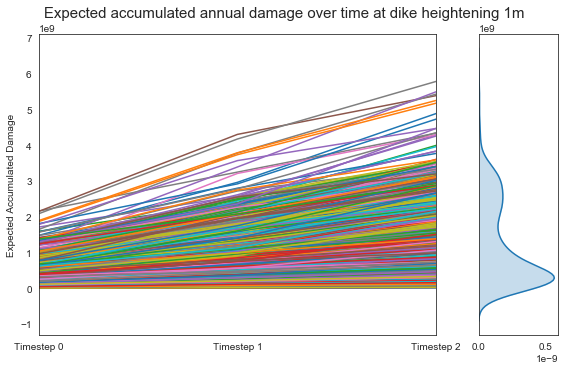

In [17]:
## visualize (accumulated) expected annual damage over time

SAMPLE_SIZE = 1000 # sample out of 10,000 runs

# subset outcomes of expected annual damage
df_damage = o_DikeSmall.filter(regex='^Expected Annual Damage').sample(SAMPLE_SIZE)
df_damage = df_damage.cumsum(axis=1) # accumulate damage over time
df_damage.columns = ['Timestep 0', 'Timestep 1', 'Timestep 2']

from matplotlib import gridspec

fig = plt.figure(figsize=(8, 5))
gs = gridspec.GridSpec(1,2, width_ratios=[5, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharey=ax1)
ax1.set_ylabel('Expected Accumulated Damage')

df_damage.T.plot(legend=False, ax=ax1)
sns.distplot(df_damage['Timestep 2'], hist=False, vertical=True, 
             ax=ax2, kde_kws={'shade': True})

fig.suptitle('Expected accumulated annual damage over time at dike heightening 1m', y=1.02, fontsize=15)
gs.tight_layout(fig, rect=[0, 0, 1, 1])

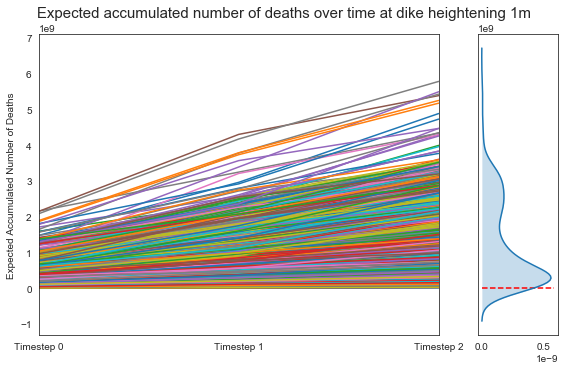

In [18]:
## visualize expected number of deaths over time

NR_DEATH_THRESHOLD = 1

# subset outcomes of expected annual damage
df_deaths = o_DikeSmall.loc[df_damage.index, :].filter(regex='^Expected Annual Damage')
df_deaths = df_deaths.cumsum(axis=1) # accumulate deaths over time
df_deaths.columns = ['Timestep 0', 'Timestep 1', 'Timestep 2']

from matplotlib import gridspec

fig = plt.figure(figsize=(8, 5))
gs = gridspec.GridSpec(1,2, width_ratios=[5, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharey=ax1)
ax1.set_ylabel('Expected Accumulated Number of Deaths')

df_deaths.T.plot(legend=False, ax=ax1)
sns.distplot(df_deaths['Timestep 2'], kde=True, hist=False, vertical=True, 
             ax=ax2, kde_kws={'shade': True})
ax2.hlines(NR_DEATH_THRESHOLD, ax2.get_xlim()[0], ax2.get_xlim()[1],
           linestyle = '--', colors='r')

fig.suptitle('Expected accumulated number of deaths over time at dike heightening 1m', y=1.02, fontsize=15)
gs.tight_layout(fig, rect=[0, 0, 1, 1])

## Dike heightening - medium scale (5 m)

In [14]:
# subset the uncertainties and outcomes for policy small scale dike heightening
u_DikeMedium = experiments.loc[experiments.policy == 'policyDike1', :]
u_DikeMedium = u_DikeMedium.filter(regex=r'(wave shape$|Bmax$|pfail$|Brate$|^discount)')
o_DikeMedium = pd.DataFrame.from_dict(outcomes).loc[u_DikeMedium.index, :]
o_DikeMedium = o_DikeMedium.filter(regex=r'(^Expected Annual Damage|^Expected Number of Deaths|^Dike Investment Costs)')

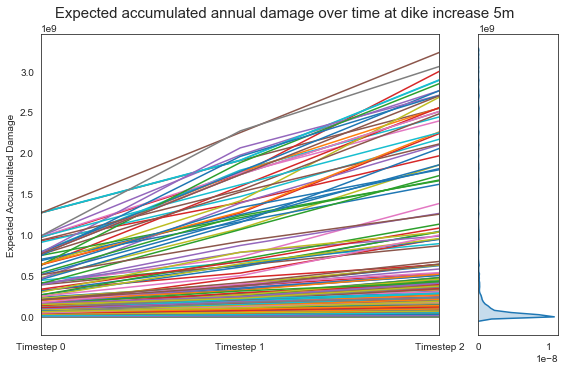

In [15]:
## visualize (accumulated) expected annual damage over time

SAMPLE_SIZE = 1000 # sample out of 10,000 runs

# subset outcomes of expected annual damage
df_damage = o_DikeMedium.filter(regex='^Expected Annual Damage').sample(SAMPLE_SIZE)
df_damage = df_damage.cumsum(axis=1) # accumulate damage over time
df_damage.columns = ['Timestep 0', 'Timestep 1', 'Timestep 2']

from matplotlib import gridspec

fig = plt.figure(figsize=(8, 5))
gs = gridspec.GridSpec(1,2, width_ratios=[5, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharey=ax1)
ax1.set_ylabel('Expected Accumulated Damage')

df_damage.T.plot(legend=False, ax=ax1)
sns.distplot(df_damage['Timestep 2'], hist=False, vertical=True, 
             ax=ax2, kde_kws={'shade': True})

fig.suptitle('Expected accumulated annual damage over time at dike increase 5m', y=1.02, fontsize=15)
gs.tight_layout(fig, rect=[0, 0, 1, 1])

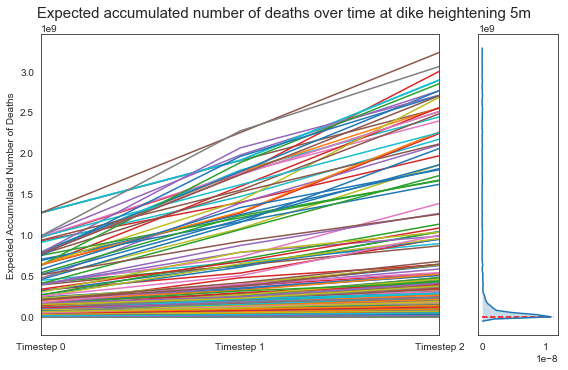

In [16]:
## visualize expected number of deaths over time

NR_DEATH_THRESHOLD = 1

# subset outcomes of expected annual damage
df_deaths = o_DikeMedium.loc[df_damage.index, :].filter(regex='^Expected Annual Damage')
df_deaths = df_deaths.cumsum(axis=1) # accumulate deaths over time
df_deaths.columns = ['Timestep 0', 'Timestep 1', 'Timestep 2']

from matplotlib import gridspec

fig = plt.figure(figsize=(8, 5))
gs = gridspec.GridSpec(1,2, width_ratios=[5, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharey=ax1)
ax1.set_ylabel('Expected Accumulated Number of Deaths')

df_deaths.T.plot(legend=False, ax=ax1)
sns.distplot(df_deaths['Timestep 2'], kde=True, hist=False, vertical=True, 
             ax=ax2, kde_kws={'shade': True})
ax2.hlines(NR_DEATH_THRESHOLD, ax2.get_xlim()[0], ax2.get_xlim()[1],
           linestyle = '--', colors='r')

fig.suptitle('Expected accumulated number of deaths over time at dike heightening 5m', y=1.02, fontsize=15)
gs.tight_layout(fig, rect=[0, 0, 1, 1])

## PRIM